In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import aux_functions

## Read dataset

In [2]:
hardbounce = pd.read_csv('datasets/hardbounce_featureEngineering.csv',sep=';')

## Build dummy variables

In [3]:
cat_vars=['emailDomain_cat','emailDomainPiece1','emailDomainPiece2']

hardbounce_dummy = aux_functions.buildDummyVariables(hardbounce, cat_vars)

## Check imbalance

In [4]:
aux_functions.freqTable(
    hardbounce_dummy['flgHardBounce_n']
    ,""
    ,False
    ,"columns"
)

flgHardBounce_n
0    0.787886
1    0.212114
Name: __dummy__, dtype: float64

In [5]:
x_vars = ['monthsSinceRegDate', 'age', 'percNumbersInEmailUser', 'emailUserCharQty', 
          'emailDomain_cat_gmail.com', 'emailDomain_cat_hotmail.com',
          'emailDomainPiece1_com',
          'emailDomainPiece2_br', 'emailDomainPiece2_missing']

X = hardbounce_dummy[x_vars]

y = hardbounce_dummy['flgHardBounce_n']

## Split dataset in Train / Test

In [6]:
from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(338377, 9)
(145019, 9)
(338377,)
(145019,)


## Extreme Gradient Boosting (XGBoost)

In [7]:
import xgboost as xgb
from sklearn import metrics

In [8]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

/home/thiago/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [9]:
# XGBoost Classifier Train

xgb_classif = xgb.XGBClassifier(
    max_depth=5, 
    objective='reg:logistic', 
    random_state=123)

xgb_classif.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Probability Thresholds

(0, 1)

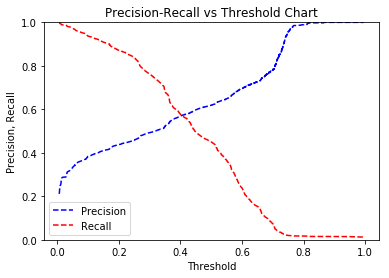

In [10]:
from sklearn.metrics import precision_recall_curve

# Predict
y_scores_threshold = xgb_classif.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_threshold) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [11]:
# XGBoost Classifier predict

threshold = 0.4

y_pred = np.where(xgb_classif.predict_proba(X_test)[:,1] > threshold, 1, 0)
y_scores = xgb_classif.predict_proba(X_test)[:,1]

### F1-score, precision and recall

In [12]:
from sklearn.metrics import classification_report
target_names = hardbounce_dummy['flgHardBounce_n'].astype('str').unique()
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.89      0.88      0.88    114385
           0       0.57      0.58      0.57     30634

    accuracy                           0.82    145019
   macro avg       0.73      0.73      0.73    145019
weighted avg       0.82      0.82      0.82    145019



### Accuracy

In [13]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8185892883001538


### Plot Confusion Matrix

Normalized confusion matrix
[[0.883455   0.116545  ]
 [0.42361428 0.57638572]]


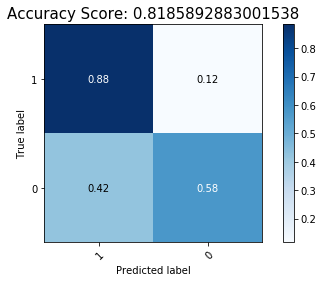

In [14]:
class_names = hardbounce_dummy['flgHardBounce_n'].astype('str').unique()
aux_functions.plot_confusion_matrix(y_test, y_pred, classes=class_names, cmap=plt.cm.Blues, normalize=True)

### AVG Precision Score

In [36]:
print("AVG Precision Score: ", metrics.average_precision_score(y_test, y_scores))

AVG Precision Score:  0.5958132213689207


### AUC

In [37]:
auc_metric = metrics.roc_auc_score(y_test, y_scores)
print("AUC: %.4f" % auc_metric)

AUC: 0.8603


### ROC Curve

AUC: 0.8603


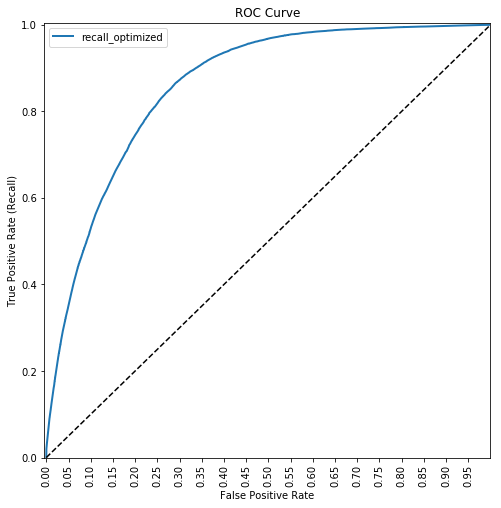

In [38]:
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_scores)
print("AUC: %.4f" % metrics.auc(fpr, tpr)) # AUC of ROC
aux_functions.plot_roc_curve(fpr, tpr, 'recall_optimized')

### Plot XGB Tree

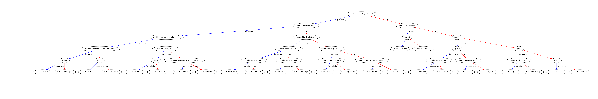

In [39]:
xgb.plot_tree(xgb_classif,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 70]
plt.show()

### Plot Variable Importance

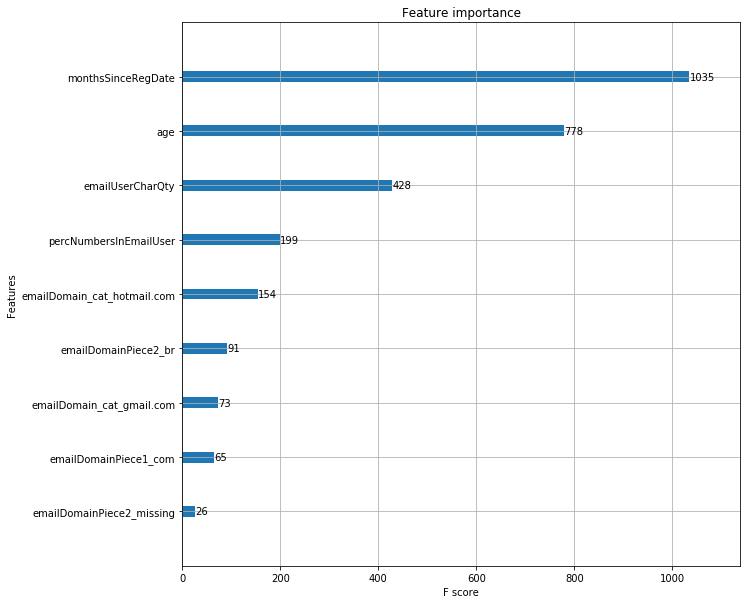

In [41]:
xgb.plot_importance(xgb_classif)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

## Save Model

In [42]:
import pickle

pickle.dump(xgb_classif, open('models/xgb-classifier-withImbalance.sav', 'wb'))